In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Подключение к БД

In [92]:
load_dotenv(dotenv_path=r'C:\Users\User\Downloads\Пет-проекты\marketplace_users_data\config.env')  # Загрузка переменных из .env

db_url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}/{os.getenv('DB_NAME')}"
engine = create_engine(db_url)

In [93]:
query_purchases = """
    SELECT *
    FROM purchases
"""

In [94]:
df_purchases = pd.read_sql(query_purchases, engine, parse_dates=['purchase_date'])
df_purchases.sample(5)

,id,user_id,purchase_date,amount,category
2620,2621,234,2025-08-04,164.83,ELECTRONICS
1927,1928,2,2024-01-03,497.19,TOYS
279,280,165,2024-10-31,499.32,SPORTS
2378,2379,160,2024-08-20,381.00,CLOTHING
2944,2945,408,2024-08-24,676.26,FOOD


In [95]:
query_users = """
    SELECT *
    FROM users
"""

In [96]:
df_users = pd.read_sql(query_users, engine, parse_dates=['join_date'])
df_users.sample(5)

,id,name,age,city,profession,join_date
300,301,Charles Hughes,64.0,PORT SAVANNAHCHESTER,ARTIST,2022-10-31
238,239,Brett Woods,90.0,RICHARDFORT,DOCTOR,2025-08-04
53,54,Unknown,44.0,MANUELMOUTH,DEVELOPER,2022-10-20
84,85,Cheryl Collins,54.0,JONATHANVILLE,DOCTOR,2024-06-07
233,234,Mary Rhodes,27.0,ALLENLAND,UNKNOWN PROFESSION,2021-09-12


# ABC - анализ

### Проведение этого ABC-анализа поможет распределить пользователей в три группы (A, B, C) в зависимости от их вклада в общий доход компании.

Объединим датафреймы df_users и df_purchases

In [157]:
df_merge = df_users.merge(df_purchases, left_on='id', right_on='user_id')
df_merge = df_merge.drop(columns=['id_x', 'id_y'])
df_merge

,name,age,city,profession,join_date,user_id,purchase_date,amount,category
0,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2024-08-20,591.91,SPORTS
1,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2023-10-30,181.50,CLOTHING
2,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2024-06-21,561.25,ELECTRONICS
3,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2024-12-03,765.82,UNKNOWN CATEGORY
4,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2024-04-05,310.44,CLOTHING
...,...,...,...,...,...,...,...,...,...
2995,Eric Johnson,23.0,LARRYSIDE,ENGINEER,2021-01-23,500,2024-01-02,87.79,BOOKS
2996,Eric Johnson,23.0,LARRYSIDE,ENGINEER,2021-01-23,500,2024-07-09,167.33,ELECTRONICS
2997,Eric Johnson,23.0,LARRYSIDE,ENGINEER,2021-01-23,500,2023-11-15,920.19,TOYS
2998,Eric Johnson,23.0,LARRYSIDE,ENGINEER,2021-01-23,500,2023-11-23,615.93,CLOTHING


Создадим датафрейм, где сгруппируем датафрейм по пользователям рассчитаем сумму покупок

In [158]:
df_users_purchase_amount = df_merge.groupby('user_id').agg(purchase_amount = ('amount','sum'),).reset_index()
df_users_purchase_amount

,user_id,purchase_amount
0,1,2410.920
1,2,3354.285
2,3,2645.130
3,4,3134.420
4,5,3807.335
...,...,...
495,496,1516.650
496,497,3595.705
497,498,4696.245
498,499,2462.020


Отсортируем пользователей по сумме покупок

In [159]:
df_users_purchase_amount = df_users_purchase_amount.sort_values('purchase_amount', ascending=False).reset_index(drop=True)
df_users_purchase_amount

,user_id,purchase_amount
0,489,7702.230
1,324,7328.825
2,450,7195.645
3,434,6694.390
4,215,6471.835
...,...,...
495,493,504.095
496,73,492.980
497,417,464.380
498,435,464.210


Рассчитаем накопительную сумму покупок

In [160]:
df_users_purchase_amount['cumsum_purchase_amount'] = df_users_purchase_amount['purchase_amount'].cumsum()
df_users_purchase_amount

,user_id,purchase_amount,cumsum_purchase_amount
0,489,7702.230,7702.230
1,324,7328.825,15031.055
2,450,7195.645,22226.700
3,434,6694.390,28921.090
4,215,6471.835,35392.925
...,...,...,...
495,493,504.095,1509264.120
496,73,492.980,1509757.100
497,417,464.380,1510221.480
498,435,464.210,1510685.690


Оперелим её долю в общем доходе

In [161]:
df_users_purchase_amount['cumsum_purchase_amount_per'] = df_users_purchase_amount['cumsum_purchase_amount'] / df_users_purchase_amount['purchase_amount'].sum()
df_users_purchase_amount

,user_id,purchase_amount,cumsum_purchase_amount,cumsum_purchase_amount_per
0,489,7702.230,7702.230,0.005097
1,324,7328.825,15031.055,0.009947
2,450,7195.645,22226.700,0.014709
3,434,6694.390,28921.090,0.019140
4,215,6471.835,35392.925,0.023423
...,...,...,...,...
495,493,504.095,1509264.120,0.998814
496,73,492.980,1509757.100,0.999140
497,417,464.380,1510221.480,0.999448
498,435,464.210,1510685.690,0.999755


Определим группу для каждого пользователя (**A**, **B** или **C**)

In [162]:
def abc_group(cumsum_purchase_amount_per):
    return 'A' if cumsum_purchase_amount_per <= 0.8 else 'B' if cumsum_purchase_amount_per <=0.9 else 'C'
df_users_purchase_amount['ABC'] = df_users_purchase_amount['cumsum_purchase_amount_per'].apply(abc_group)
df_users_purchase_amount

,user_id,purchase_amount,cumsum_purchase_amount,cumsum_purchase_amount_per,ABC
0,489,7702.230,7702.230,0.005097,A
1,324,7328.825,15031.055,0.009947,A
2,450,7195.645,22226.700,0.014709,A
3,434,6694.390,28921.090,0.019140,A
4,215,6471.835,35392.925,0.023423,A
...,...,...,...,...,...
495,493,504.095,1509264.120,0.998814,C
496,73,492.980,1509757.100,0.999140,C
497,417,464.380,1510221.480,0.999448,C
498,435,464.210,1510685.690,0.999755,C


In [163]:
df_users_purchase_amount['ABC'].value_counts(normalize=True) * 100

ABC
A    63.0
C    23.4
B    13.6
Name: proportion, dtype: float64

Согласно принципу Парето, 20% объектов должны приносить 80% результата. Как видно из результатов, 80% выручки приносят нам 63% пользователей, что не соответствует распределению пользователей по принципу Парето.   

Попробуем вручную определить границы используя доли товаров:

In [164]:
last_index_A = df_users_purchase_amount[df_users_purchase_amount['cumsum_purchase_amount_per'] <= 0.80].index.max()
last_index_B = df_users_purchase_amount[df_users_purchase_amount['cumsum_purchase_amount_per'] <= 0.95].index.max()

print(f"Граница A: {last_index_A}")
print(f"Граница B: {last_index_B}")

Граница A: 314
Граница B: 426


In [165]:
def get_abc_category(index):
    if index <= last_index_A:
        return 'A'
    elif index <= last_index_B:
        return 'B'
    else:
        return 'C'

df_users_purchase_amount['ABC'] = df_users_purchase_amount.index.map(get_abc_category)
df_users_purchase_amount

,user_id,purchase_amount,cumsum_purchase_amount,cumsum_purchase_amount_per,ABC
0,489,7702.230,7702.230,0.005097,A
1,324,7328.825,15031.055,0.009947,A
2,450,7195.645,22226.700,0.014709,A
3,434,6694.390,28921.090,0.019140,A
4,215,6471.835,35392.925,0.023423,A
...,...,...,...,...,...
495,493,504.095,1509264.120,0.998814,C
496,73,492.980,1509757.100,0.999140,C
497,417,464.380,1510221.480,0.999448,C
498,435,464.210,1510685.690,0.999755,C


In [166]:
df_users_purchase_amount['ABC'].value_counts(normalize=True) * 100

ABC
A    63.0
B    22.4
C    14.6
Name: proportion, dtype: float64

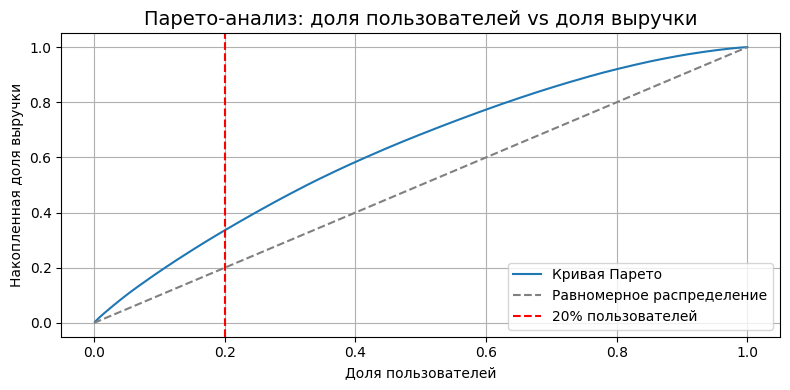

In [167]:
df_users_purchase_amount_sorted = df_users_purchase_amount.sort_values(by='purchase_amount', ascending=False).reset_index(drop=True)
df_users_purchase_amount_sorted['cumsum_purchase_amount_per'] = df_users_purchase_amount_sorted['purchase_amount'].cumsum() / df_users_purchase_amount_sorted['purchase_amount'].sum()
df_users_purchase_amount_sorted['user_share'] = (df_users_purchase_amount_sorted.index + 1) / len(df_users_purchase_amount_sorted)

plt.figure(figsize=(8, 4))
sns.lineplot(x=df_users_purchase_amount_sorted['user_share'], y=df_users_purchase_amount_sorted['cumsum_purchase_amount_per'], label='Кривая Парето')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Равномерное распределение')
plt.axvline(x=0.2, color='red', linestyle='--', label='20% пользователей')

plt.title('Парето-анализ: доля пользователей vs доля выручки', fontsize=14)
plt.xlabel('Доля пользователей')
plt.ylabel('Накопленная доля выручки')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Анализ структуры выручки по пользователям, как в табличной форме, так и через график Парето, показал отклонение от классической модели 80/20. Для достижения 80% выручки требуется привлечь более 60% пользователей, а 20% лучших пользователей генерируют менее 40% выручки. Это говорит о низкой концентрации выручки и более равномерном распределении доходов между пользователями, т.е. нет ярко выраженных «крупных» плательщиков, которые обеспечивают основную часть дохода, а большая часть пользователей приносит примерно сопоставимый доход.

Такая структура характерна для моделей с широкой пользовательской базой и отсутствием ярко выраженных крупных плательщиков (например, маркетплейсы). Это требует адаптации ABC-сегментации: вместо фокусировки на узкой группе топ-пользователей целесообразно рассматривать расширенную группу A.

# XYZ-анализ

Данный анализ поможет понять, как меняются покупки каждого пользователя по месяцам, выделить стабильных и непредсказуемых покупателей

Для анализа возьмём наш объединенный датафрейм df_merge. Добавим туда колонку месяца даты покупки

In [168]:
df_merge['month_purchase'] = df_merge['purchase_date'].dt.month
df_merge

,name,age,city,profession,join_date,user_id,purchase_date,amount,category,month_purchase
0,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2024-08-20,591.91,SPORTS,8
1,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2023-10-30,181.50,CLOTHING,10
2,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2024-06-21,561.25,ELECTRONICS,6
3,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2024-12-03,765.82,UNKNOWN CATEGORY,12
4,Joel Morales,32.0,WEST IVANBURGH,ENGINEER,2021-05-14,1,2024-04-05,310.44,CLOTHING,4
...,...,...,...,...,...,...,...,...,...,...
2995,Eric Johnson,23.0,LARRYSIDE,ENGINEER,2021-01-23,500,2024-01-02,87.79,BOOKS,1
2996,Eric Johnson,23.0,LARRYSIDE,ENGINEER,2021-01-23,500,2024-07-09,167.33,ELECTRONICS,7
2997,Eric Johnson,23.0,LARRYSIDE,ENGINEER,2021-01-23,500,2023-11-15,920.19,TOYS,11
2998,Eric Johnson,23.0,LARRYSIDE,ENGINEER,2021-01-23,500,2023-11-23,615.93,CLOTHING,11


Соберём таблицу с суммой покупок по каждому пользователю по каждому месяцу (временной ряд продаж):

In [169]:
monthly_amount = df_merge.groupby(['user_id', 'month_purchase']).agg(purchase_amount = ('amount', 'sum'),).reset_index()
monthly_amount

,user_id,month_purchase,purchase_amount
0,1,4,310.44
1,1,6,561.25
2,1,8,591.91
3,1,10,181.50
4,1,12,765.82
...,...,...,...
2298,499,11,127.73
2299,500,1,87.79
2300,500,3,743.03
2301,500,7,167.33


Для наглядности преобразуем получившуюся таблицу в сводную.

In [170]:
month_matrix = monthly_amount.pivot(index='user_id', columns='month_purchase', values='purchase_amount').fillna(0)
month_matrix.head(10)

month_purchase,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1,0.00,0.00,0.000,310.44,0.000,561.25,0.000,591.910,0.00,181.50,0.0,765.82
2,497.19,0.00,0.000,0.00,595.575,324.81,0.000,884.580,1052.13,0.00,0.0,0.00
3,883.49,270.00,0.000,0.00,386.180,0.00,0.000,0.000,0.00,0.00,729.9,375.56
4,0.00,0.00,0.000,0.00,0.000,0.00,963.800,106.410,918.17,0.00,0.0,1146.04
5,0.00,0.00,0.000,0.00,0.000,0.00,504.095,1281.970,921.09,0.00,0.0,1100.18
6,0.00,0.00,1216.830,646.51,545.020,0.00,0.000,1788.210,464.27,0.00,0.0,1035.55
7,0.00,544.22,0.000,0.00,535.000,864.11,0.000,376.790,0.00,0.00,0.0,1283.15
8,0.00,716.14,316.330,671.13,0.000,0.00,185.880,0.000,198.26,0.00,0.0,0.00
9,778.77,376.95,0.000,0.00,0.000,82.72,501.210,504.095,182.33,473.54,0.0,0.00


Рассчитаем среднее сумму покупок, стандартное отклонение и коэффициент вариации:

In [171]:
matrix_clean = month_matrix.replace(0, np.nan)
month_stat = pd.DataFrame({
    'user_id' : matrix_clean.index,
    'avg_amount' : matrix_clean.mean(axis=1),
    'std_amount' : matrix_clean.std(axis=1)
}).reset_index(drop=True)
month_stat['cv'] = month_stat['std_amount'] / month_stat['avg_amount']
month_stat

,user_id,avg_amount,std_amount,cv
0,1,482.184000,233.798780,0.484875
1,2,670.857000,294.373383,0.438802
2,3,529.026000,263.175964,0.497473
3,4,783.605000,462.071486,0.589674
4,5,951.833750,332.872208,0.349717
...,...,...,...,...
495,496,505.550000,364.925133,0.721838
496,497,513.672143,463.011457,0.901375
497,498,587.030625,465.918261,0.793686
498,499,492.404000,458.913572,0.931986


Присвоим группы коэффициенту вариации

In [172]:
month_stat['XYZ'] = month_stat['cv'].apply(lambda x: 'X' if x <= 0.3 else 'Y' if x <=0.7 else 'Z')
month_stat


,user_id,avg_amount,std_amount,cv,XYZ
0,1,482.184000,233.798780,0.484875,Y
1,2,670.857000,294.373383,0.438802,Y
2,3,529.026000,263.175964,0.497473,Y
3,4,783.605000,462.071486,0.589674,Y
4,5,951.833750,332.872208,0.349717,Y
...,...,...,...,...,...
495,496,505.550000,364.925133,0.721838,Z
496,497,513.672143,463.011457,0.901375,Z
497,498,587.030625,465.918261,0.793686,Z
498,499,492.404000,458.913572,0.931986,Z


In [174]:
month_stat['XYZ'].value_counts(normalize=True) * 100

XYZ
Y    53.8
Z    34.2
X    12.0
Name: proportion, dtype: float64

Проведенный XYZ-анализ показывает, что:
*   Около 54% пользователей относятся к категории Y — с умеренной вариабельностью суммы покупок по месяцам. Это означает, что их поведение относительно выручки несколько нестабильно, но без резких скачков.
*   34% пользователей имеют высокую вариабельность (категория Z), что говорит о сильных колебаниях их суммы покупок — они могут быть непредсказуемыми с точки зрения выручки.
*   Только около 12% пользователей характеризуются стабильностью и предсказуемостью в покупках (категория X).    

Такая структура свидетельствует о том, что значительная часть пользователей демонстрирует нестабильное, переменчивое поведение по суммам покупок.

# Объединение ABC и XYZ анализа

In [207]:
results = df_users_purchase_amount[['user_id', 'ABC']].merge(month_stat[['user_id', 'XYZ']], on='user_id', how='left')
results['ABC_XYZ'] = results['ABC'] + results['XYZ']
results

,user_id,ABC,XYZ,ABC_XYZ
0,489,A,Y,AY
1,324,A,Y,AY
2,450,A,Z,AZ
3,434,A,Z,AZ
4,215,A,Y,AY
...,...,...,...,...
495,493,C,Z,CZ
496,73,C,X,CX
497,417,C,Z,CZ
498,435,C,Z,CZ


In [208]:
results['ABC_XYZ'].value_counts(normalize=True) * 100

ABC_XYZ
AY    38.2
AZ    18.4
BY    11.8
BZ     8.0
CZ     7.8
AX     6.4
CY     3.8
CX     3.0
BX     2.6
Name: proportion, dtype: float64

# Выводы и рекомендации

## Выводы

На основе проведенного ABC-XYZ анализа можно сделать следующие выводы:
*   Наибольшая часть (38.2%) приходится на группу AY — это пользователи с высоким вкладом в доход (группа A по ABC) и средней вариабельностью покупок (категория Y по XYZ). Это ключевая стабильная сегментация клиентов, к которой стоит уделить внимание для удержания и развития.
*   Значительная доля (18.4%) — AZ: высокоценовые, но с высокой вариабельностью. Такой сегмент требует специальных мер по снижению нестабильности и более гибкого управления.
*   Группы BY, BZ, CZ — клиенты со средним и низким вкладом и разной степенью нестабильности, что составляет значительную часть базы и требует дифференцированных маркетинговых стратегий.
*   Группы AX, CY, CX, BX — меньшие по объему сегменты с разной стабильностью, но низким или средним вкладом.

## Рекомендации

__Группа AY__: крупные клиенты с умеренной вариабельностью покупок. 
*  Удерживать и развивать их через персонализированные предложения, программы лояльности и регулярные коммуникации.

__Группа AZ__: крупные, но нестабильные клиенты. 
*  Меры по увеличению частоты покупок: акции с ограниченным сроком, напоминания, бонусы, анализ причин редких покупок.

__Группы BY, BZ, CZ__: средний и низкий вклад с разной степенью нестабильности.
*    Сегментированные маркетинговые кампании — скидки, рассылки, стимулирование активности с учетом рентабельности.

__Группы AX, CY, CX, BX__: меньшие по объему с разной стабильностью.
*   __для AX__ — VIP-услуги и удержание
*   __для остальных__ — оценка затрат и выгоды удержания, при необходимости передача партнёрам.